### Step 0. Requirements, colab-data

In [ ]:
!git clone https://github.com/AnnaMedved/Buildings-NN

# Ubcomment is using colab: 
%cd /content/Buildings-NN
!pip install -r requirements.txt

In [1]:
#  Libraries
import pandas as pd 
import os
import numpy as np
import json 
import random
import torch
import src.transforms as T
import src.utils as utils

from src.engine import train_one_epoch, evaluate
from src.dataset import FacadesDataset

from pycocotools.coco import COCO
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# Colab input data here
!pip install gdown
!gdown --fuzzy yourlinkhere

!pip install patool

import patoolib
!unzip buildings_train_v1.zip -d data

### **Step 1**. Transform initial COCO data to the masks 

At first, let's see what's happening with photos

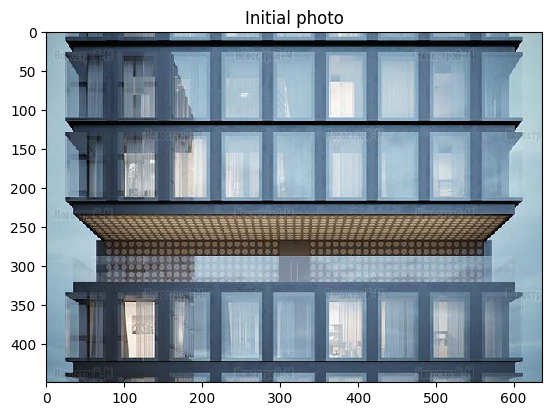

In [2]:
im_path = 'data/images'
res_path = 'data/result.json'

with open(res_path, 'r') as f: 
    res_json = json.load(f)
images_df = pd.DataFrame(res_json['images'])

# Get random photo and visualize it 
id_rand = random.randint(0, len(images_df)-1)
name_rand = images_df.loc[id_rand, 'file_name']
image = np.array(Image.open(os.path.join('data', name_rand)))
plt.imshow(image, interpolation='nearest')
plt.title('Initial photo')
plt.show()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


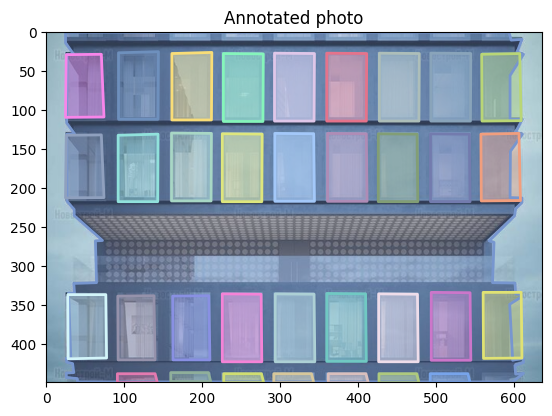

In [3]:
# Load the annotations from COCO format 
coco = COCO(res_path)
img = coco.imgs[id_rand]

# Visualize annotations 
plt.imshow(image)
plt.title('Annotated photo')
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

Text(0.5, 1.0, 'Mask-only')

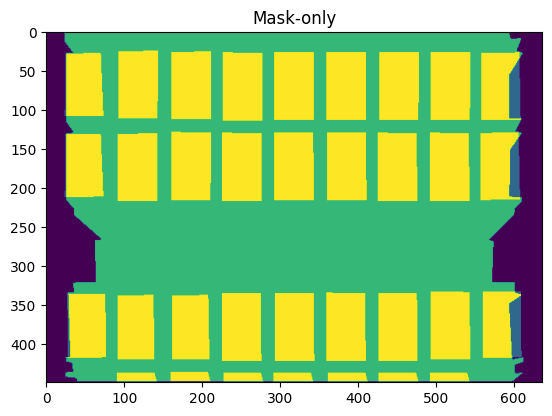

In [4]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)
plt.title('Mask-only')

... and creating these masks as part of the initializing FacadesDataset:

In [5]:
# class MyCompose(object):
#     '''Solving the error of torchvision.Compose()'''
    
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, img, tar):
#         for t in self.transforms:
#             img, tar = t(img, tar)
#         return img, tar

import src.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# trans = MyCompose([transform_ToNumpy()])

im_path = 'data/images'
res_path = 'data/result.json'

with open(res_path, 'r') as f: 
    res_json = json.load(f)
images_df = pd.DataFrame(res_json['images'])

data_dir = 'data'
coco_json = 'data/result.json'

# use our dataset and defined transformations
dataset = FacadesDataset(
    data_path=data_dir, 
    coco_json_path=coco_json,
    transforms=get_transform(train=True)
    )
dataset_test = FacadesDataset(
    data_path=data_dir, 
    coco_json_path=coco_json,
    transforms=get_transform(train=True)
    )

ids = images_df.id.unique()
train_ids = np.random.choice(a=ids, size=int(len(images_df)*0.75))
valid_ids = set(ids) - set(train_ids)
# torch.manual_seed(5)
# indices = torch.randperm(len(dataset)).tolist()

# Split the dataset into train and test set
dataset = torch.utils.data.Subset(dataset, train_ids)
dataset_test = torch.utils.data.Subset(dataset_test, valid_ids)

# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

2
2


### **Step 2**. Model training and validation

Let's define our model and its parameters

In [6]:
from src.model_building import build_model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

a:\Programs\Python_3_8_5\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
a:\Programs\Python_3_8_5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


... and finally the training

In [7]:
# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

RuntimeError: DataLoader worker (pid(s) 20368, 9036, 17536, 9264) exited unexpectedly